In [ ]:
import os
import glob

from pathlib import Path
from itertools import groupby

from scheduler_runtime_stats import parse_scheduler_runtimes, parse_result, parse_slo

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [25]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

In [3]:
def scheduler_runtime_csv_files():
    for root, _, files in os.walk("alibaba_scheduler_runtime-dsched"):
        if root == "alibaba_scheduler_runtime-dsched":
            continue
        for file in files:
            if file.endswith(".csv"):
                yield os.path.join(root, file)

In [9]:
def parse_label(file):
    file = Path(file)
    sched = file.parts[1]
    arrival_rate = sum(map(float, file.parts[2].split("::")[1].split(":")))
    return sched, arrival_rate

In [30]:
results = []
for file in scheduler_runtime_csv_files():
    data = parse_result(file)
    sched, arrival_rate = parse_label(file)
    times = parse_scheduler_runtimes(data, file)
    slo = parse_slo(data)
    results.append(
        (sched, arrival_rate, slo, times)
    )

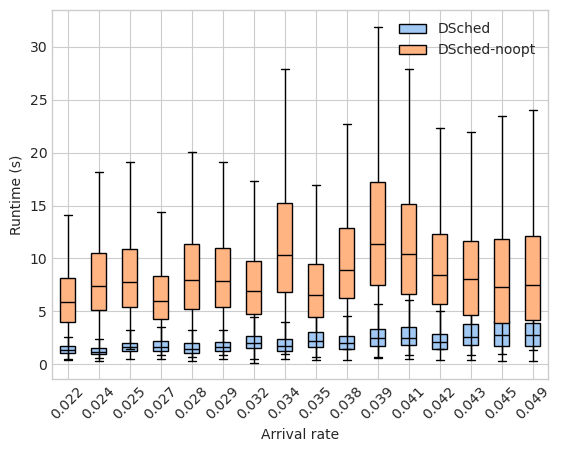

In [32]:
fig, axs = plt.subplots()
for (i, (group, result)) in enumerate(groupby(results, key=lambda x: x[0])):
    result = sorted(result, key=lambda x: x[1])

    xs = [r[1] for r in result]
    ys = [r[3] for r in result]
    boxplot = axs.boxplot(x=ys, sym='', label=group, patch_artist=True)
    for box in boxplot['boxes']:
        box.set(facecolor=sns.color_palette("pastel")[i])
    for median in boxplot['medians']:
        median.set(color='black', linewidth=1)

plt.xticks(range(1, len(xs)+1), [f'{x:.3f}' for x in xs], rotation=45)
plt.xlabel('Arrival rate')
plt.ylabel('Runtime (s)')

plt.legend()
plt.show()

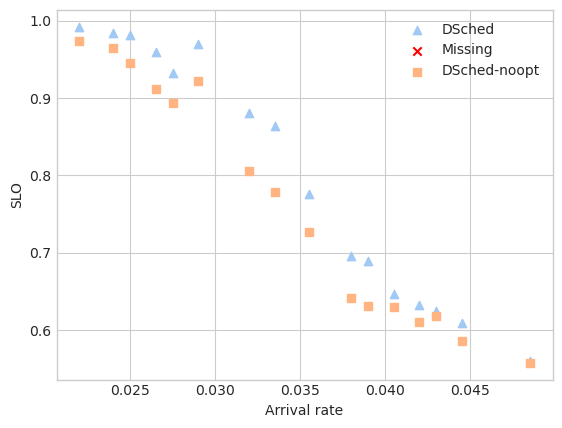

In [33]:
markers = ['^', 's']
fig, axs = plt.subplots()
for (i, (group, result)) in enumerate(groupby(results, key=lambda x: x[0])):
    result = sorted(result, key=lambda x: x[1])

    xs = np.array([r[1] for r in result])
    ys = np.array([r[2] for r in result], dtype=float)
    mask = ~np.isnan(ys)
    axs.scatter(xs[mask], ys[mask], label=group, marker=markers[i])

    nan_mask = np.isnan(ys)
    axs.scatter(xs[nan_mask], [0.50]*sum(nan_mask), marker='x', color='red', label='Missing')

plt.xlabel('Arrival rate')
plt.ylabel('SLO')

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))  # keeps last occurrence; use reversed(...) to keep first
plt.legend(unique.values(), unique.keys())
plt.show()

/tmp/ipykernel_3386552/3954942550.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


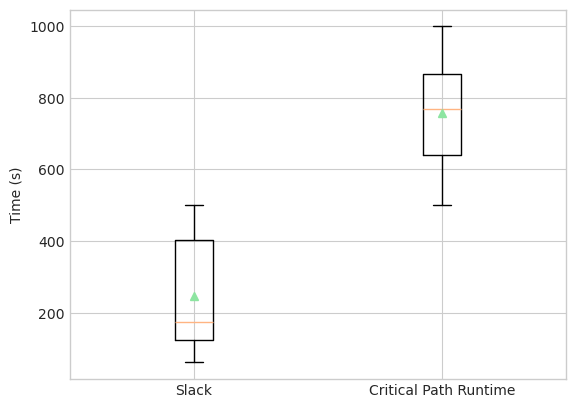

In [29]:
for file in scheduler_runtime_csv_files():
    data = parse_result(file)
    sched, arrival_rate = parse_label(file)

    slacks = []
    cprs = []
    for row in data:
        parts = row.split(",")
        if parts[1] == "TASK_GRAPH_RELEASE":
            release_time = float(parts[2])
            deadline = float(parts[3])
            critical_path_runtime = float(parts[-1])
            slack = deadline - (release_time + critical_path_runtime)

            slacks.append(slack)
            cprs.append(critical_path_runtime)

    fig, ax = plt.subplots()

    ax.boxplot([slacks, cprs], showmeans=True)
    ax.set_xticklabels(["Slack", "Critical Path Runtime"])
    ax.set_ylabel("Time (s)")
    plt.legend()
    plt.show()

    break